



#             Badanie internetowe stopnia makiawelizmu respondentów





Dane wykorzystane w niniejszej pracy pochodzą z ogólnodostępnej bazy odpowiedzi respondentów na ankietę badającą stopień 
makiawelizmu ('MACH IV' - `https://openpsychometrics.org/_rawdata/`). Badanie zawiera 20 stwierdzeń. Respondenci określają
na 5 stopniowej skali Likerta w jakim stopniu utożsamiają się z danym stwierdzeniem.<br>
<br>
Przykład pytania: Największa różnica między większością kryminalistów, a resztą ludzi jest taka, że kryminaliści dają się złapać.<br>
Dostępne odpowiedzi kodowane w kolejności: <br>
1 = Zdecydowanie nie zgadzam się; <br>
2 = Raczej się nie zgadzam; <br>
3 = Nie mam zdania; <br>
4 = Raczej się zgadzam; <br>
5 = Zdecydowanie się zgadzam<br>
<br>
Poza 20 pytaniami, zebrane zostały również metryki dotyczące respondentów. Poniżej przedstawione są tylko te, które zostały 
wybrane do wykorzystania w toku niniejszej analizy. <br>
    1. wykształcenie,<br>
    2. aktualny kraj zamieszkania - ustalony na podstawie adresów IP,<br>
    3. obszar zamieszkania w dzieciństwie,<br>
    4. płeć respondenta,<br>
    5. wiek respondenta,<br>
    6. rasa,<br>
    7. status małżeński,<br>
    8. liczba rodzeństwa.<br>

###### Wymagane biblioteki:

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rnd
import pyodbc
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import sys
from sklearn.impute import KNNImputer
sys.setrecursionlimit(100000)
from scipy import stats


pd.reset_option('display.float_format')


Surowe dane zostały załadowane poprzez pliki csv do MS SQL Server. Na poziomie serwera stworzone zostały dodatkowe słowniki, które przy pomocy połączeń (JOIN) umożliwiły zmianę danych z kodowania numerycznego na odpowiadające im rzeczywiste wartości. Poniżej przedstawiony został kod SQL służący utworzeniu przykładowych tabeli słowników i zasileniu ich w dane. Czynność ta została wykonana dla wszystkich zakodowanych metryk dotyczących respondentów.

<font color = blue>
CREATE TABLE education ( <br>
	id tinyint NOT NULL IDENTITY(1,1) PRIMARY KEY,<br>
	education_level varchar(60),<br>
	)<br>
<br>
--education level table<br>
INSERT INTO education VALUES ('University degree')<br>
INSERT INTO education VALUES ('High school')<br>
INSERT INTO education VALUES ('University degree')<br>
INSERT INTO education VALUES ('Graduate degree')<br>
<br>
<br>
CREATE TABLE race(<br>
	id tinyint NOT NULL IDENTITY(10,10) PRIMARY KEY,<br>
	race varchar(60))<br>
<br>
--race table<br>
INSERT INTO race VALUES ('Asian')<br>
INSERT INTO race VALUES ('Arab')<br>
INSERT INTO race VALUES ('Black')<br>
INSERT INTO race VALUES ('Indigenious Australian')<br>
INSERT INTO race VALUES ('Native American')<br>
INSERT INTO race VALUES ('White')<br>
INSERT INTO race VALUES ('Other')<br>
<\font>

Tabela dotycząca danych z internetu została pobrana z `https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv`. Wartość dla kodu GB została skrócona przy pomocy funkcji <font color = blue> UPDATE </font> (poprzednia wartość - United Kingdom of Great Britain and Northern Ireland)

<font color = blue>
UPDATE country <br>
  SET name = 'United Kingdom' <br>
  WHERE <br>
  alpha_2 = 'GB' <br>
</font>

##### Podłączenie się do bazy danych i utworzenie kursora

In [2]:
server = '(LocalDb)\FirstLocalDB' 
database = 'machiavelli' 
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=yes')
cursor = cnxn.cursor()

### Pozyskiwanie odpowiedzi z bazy SQL
Zapytanie zostało wykonane w celu pozyskania ankiet dla 4 największych krajów respondentów (USA,Australia,Wielka Brytania, Kanada). Próba została ograniczona ze względu na największą różnorodność respondentów pochodzących z tych krajów. Wybór mniej licznych krajów mógłby powodować generowanie niestandardowych kombinacji podczas symulacji metryk (90 letni rdzenny australijczyk mieszkający w Polsce). Metryki zostały oczyszczone przy pomocy funkcji <font color = blue> WHERE </font> z rzędów o skrajnych, błędnych lub pustych wartościach. Wiek respondentów został ograniczony do osób dorosłych do wieku 90 lat. Dodatkowo zmienna dotycząca liczby rodzeństwa została zamieniona przy pomocy funkcji <font color = blue> CASE WHEN </font> ze skali ilorazowej na skalę porządkową.

In [3]:
sql_query = pd.read_sql_query ('''
SELECT
       Question1A
      ,Question2A
      ,Question3A
      ,Question4A
      ,Question5A
      ,Question6A
      ,Question7A
      ,Question8A
      ,Question9A
      ,Question10A
      ,Question11A
      ,Question12A
      ,Question13A
      ,Question14A
      ,Question15A
      ,Question16A
      ,Question17A
      ,Question18A
      ,Question19A
      ,Question20A
      ,c.name as country
      ,edu.education_level
      ,ha.ha_level as home_area
      ,g.gender
      ,age
      ,race.race
      ,ms.status as marital_status
      ,CASE WHEN familysize = 1 THEN 'only child' WHEN familysize = 2 THEN 'one sibling' WHEN familysize <= 5 THEN 'up to 5 siblings' WHEN familysize > 5 THEN 'over 5 siblings' ELSE NULL END as siblings 
FROM
answers ans
LEFT JOIN country c ON c.alpha_2 = ans.country
LEFT JOIN education edu ON edu.id = ans.education LEFT JOIN home_area ha ON ha.id = ans.urban 
LEFT JOIN gender g ON g.id = ans.gender  
LEFT JOIN race ON race.id = ans.race
LEFT JOIN marital_status ms ON ms.id = ans.married
WHERE
age BETWEEN 18 AND 90
AND
alpha_2 IN ('US','GB','CA','AU')
AND
familysize <= 15
and
country != 'NONE' 
AND education_level IS NOT NULL AND g.gender IS NOT NULL 
AND race.race IS NOT NULL AND familysize IS NOT NULL 
AND ms.status IS NOT NULL AND ha_level IS NOT NULL
'''
,cnxn)

Dane następnie zostają przekształcone do postaci ramki danych, w celu pogrupowania i sprawdzenia częstości występowania poszczególnych odpowiedzi. Dane te zostaną wykorzystane do zasymulowania wyników ankiety.

In [4]:
df_answers = pd.DataFrame(sql_query,
    columns = 
    ['Question1A',
    'Question2A',
    'Question3A',
    'Question4A',
    'Question5A',
    'Question6A',
    'Question7A',
    'Question8A',
    'Question9A',
    'Question10A',
    'Question11A',
    'Question12A',
    'Question13A',
    'Question14A',
    'Question15A',
    'Question16A',
    'Question17A',
    'Question18A',
    'Question19A',
    'Question20A',
    'country',
    'education_level',
    'home_area',
    'gender',
    'age',
    'race',
    'marital_status',
    'siblings'])

#### Dane - podstawowe statystyki
Poniżej przedstawiony jest wycinek tabeli danych orzymanych z bazy SQL, jej podstawowe statystyki oraz podsumowanie zmiennych jakościowych.

In [5]:
columns = df_answers.columns
metric_columns = columns[20:]
df_answers.iloc[:10,18:30]

,Question19A,Question20A,country,education_level,home_area,gender,age,race,marital_status,siblings
0,5.0,1.0,United States of America,Graduate degree,Urban,Female,49.0,Asian,Currently married,over 5 siblings
1,5.0,4.0,United States of America,High school,Suburban,Male,40.0,Native American,Currently married,up to 5 siblings
2,2.0,1.0,United States of America,University degree,Rural,Male,24.0,White,Currently married,up to 5 siblings
3,5.0,1.0,United Kingdom,High school,Urban,Male,30.0,White,Never married,one sibling
4,5.0,4.0,United States of America,High school,Suburban,Male,30.0,White,Never married,up to 5 siblings
5,5.0,5.0,United States of America,University degree,Suburban,Male,27.0,White,Never married,one sibling
6,5.0,4.0,United States of America,University degree,Urban,Male,40.0,Asian,Never married,up to 5 siblings
7,3.0,1.0,United States of America,Less than high school,Suburban,Male,18.0,Black,Never married,up to 5 siblings
8,3.0,1.0,United States of America,Graduate degree,Suburban,Male,51.0,Asian,Currently married,one sibling
9,5.0,5.0,United States of America,University degree,Rural,Male,28.0,White,Never married,up to 5 siblings


In [6]:
df_answers.describe(include = 'object')

,country,education_level,home_area,gender,race,marital_status,siblings
count,36919,36919,36919,36919,36919,36919,36919
unique,4,4,3,3,7,3,4
top,United States of America,University degree,Suburban,Male,White,Never married,up to 5 siblings
freq,26296,14515,16119,18652,27691,22239,16626


In [7]:
df_answers.iloc[:,:10].describe()

,Question1A,Question2A,Question3A,Question4A,Question5A,Question6A,Question7A,Question8A,Question9A,Question10A
count,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000
mean,3.058371,3.065955,2.849508,2.968580,3.454779,2.695523,2.186571,2.932528,3.950811,3.212709
std,1.535195,1.472047,1.424860,1.400757,1.398228,1.484488,1.359097,1.489357,1.314826,1.484490
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,3.000000,2.000000
50%,3.000000,3.000000,3.000000,3.000000,4.000000,2.000000,2.000000,3.000000,5.000000,3.000000
75%,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,3.000000,4.000000,5.000000,5.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [8]:
df_answers.iloc[:,10:20].describe()

,Question11A,Question12A,Question13A,Question14A,Question15A,Question16A,Question17A,Question18A,Question19A,Question20A
count,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000,36919.000000
mean,1.737967,3.603754,2.793792,2.170427,3.367886,2.587069,2.246594,3.378017,4.334408,2.185893
std,1.026005,1.447160,1.549018,1.204796,1.386860,1.514810,1.357722,1.407825,1.140912,1.426469
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000,4.000000,1.000000
50%,1.000000,4.000000,3.000000,2.000000,4.000000,2.000000,2.000000,4.000000,5.000000,2.000000
75%,2.000000,5.000000,4.000000,3.000000,4.000000,4.000000,3.000000,5.000000,5.000000,3.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [9]:
df_answers.age.describe()

count    36919.000000
mean        33.459113
std         13.468700
min         18.000000
25%         22.000000
50%         30.000000
75%         42.000000
max         90.000000
Name: age, dtype: float64

#### Ustalenie częstotliwości wystąpienia wartości w metrykach

Zmienne <font color = green> chance_xxx </font> służą określeniu względnej liczebności każdej z wartości w każdej z metryk. Wartości te zostaną użyte jako prawdopodbieństwo wystąpienia danej metryki dla symulowanej osoby odpowiadającej w ankiecie.

In [10]:
chance_country = df_answers.country.value_counts()/df_answers.country.count()
chance_education = df_answers.education_level.value_counts()/df_answers.education_level.count()
chance_home = df_answers.home_area.value_counts()/df_answers.home_area.count()
chance_gender = df_answers.gender.value_counts()/df_answers.gender.count()
chance_age = df_answers.age.value_counts()/df_answers.age.count()
chance_race = df_answers.race.value_counts()/df_answers.race.count()
chance_married = df_answers.marital_status.value_counts()/df_answers.marital_status.count()
chance_siblings = df_answers.siblings.value_counts()/df_answers.siblings.count()

### Symulacja ankiet
Funkcja <font color=blue> symulate_questionnaires </font> w pierwszej kolejności generuje przykładową osobę na podstawie częstości występowania wartości z metryk (kraj, poziom wykształcenia, obszar zamieszkania w dzieciństwie itd.). Następnie losowane są trzy metryki, które służą skategoryzowaniu danej osoby i odfiltrowaniu tabeli danych o odpowiedziach tylko do osób tej kategorii. Odfiltrowana tabela służy obliczeniu częstości odpowiedzi na każde z pytań dla tego typu osobników i wylosowaniu na tej podstawie odpowiedzi  (częstość występowania równe prawdopodobieństwu) na pytania dla wygenerowanej jednostki. W przypadku wystąpienia bardzo rzadkiej kombinacji (szczególnie z rasą indian, których liczebość w odpowiedziach jest niewielka) funkcja odfiltrowuje tabelę odpowiedzi tylko na podstawie miejsca zamieszkania w dzieciństwie oraz płci. Cechy te zostały wybrane na podstawie literatury, która określa, że osoby o psychopatycznych skłonnościach częściej związani są z silnie zurbanizowanymi terenami i częściej są to mężczyźni (przyp. *Wynn, R., Høiseth, M. H., & Pettersen, G. (2012). Psychopathy in women: theoretical and clinical perspectives. International journal of women's health, 4, 257–263, Perenc, L., Radochoński, M. (2016). Prevalence of psychopathic traits in a large sample of Polish adolescents from rural and urban areas. Ann Agric Environ Med., 23(2), 368-372.* ). Po wylosowaniu metryk i zasymulowaniu odpowiedzi dla każdej osoby, wszystkie wartości gromadzone są w liście list, która następnie zamieniona jest na tablicę danych o tych samych kolumnach co oryginalny zbiór. 

In [11]:
rnd.seed(99)
def symulate_questionnaires(n):
    simulated_population = []
    for i in range(0,n):
        simulated_person = []
        simulated_person.append(rnd.choices(population = list(chance_country.index),weights = list(chance_country.values), \
                                            k= 1)[0])
        simulated_person.append(rnd.choices(population = list(chance_education.index),weights = list(chance_education.values), \
                                            k= 1)[0])
        simulated_person.append(rnd.choices(population = list(chance_home.index),weights = list(chance_home.values), \
                                            k= 1)[0])
        simulated_person.append(rnd.choices(population = list(chance_gender.index),weights = list(chance_gender.values), \
                                            k= 1)[0])
        simulated_person.append(rnd.choices(population = list(chance_age.index),weights = list(chance_age.values), \
                                            k= 1)[0])
        simulated_person.append(rnd.choices(population = list(chance_race.index),weights = list(chance_race.values), \
                                            k= 1)[0])
        simulated_person.append(rnd.choices(population = list(chance_married.index),weights = list(chance_married.values), \
                                            k= 1)[0])
        simulated_person.append(rnd.choices(population = list(chance_siblings.index),weights = list(chance_siblings.values), \
                                            k= 1)[0])
        sample_index = sorted(rnd.sample(range(8),k=3))
        sampled_values = [simulated_person[inx] for inx in sample_index]
        sample_df_columns = metric_columns[sample_index]
        sliced_df = df_answers[(\
                        (df_answers[sample_df_columns[0]]==sampled_values[0]) &\
                        (df_answers[sample_df_columns[1]]==sampled_values[1]) &\
                        (df_answers[sample_df_columns[2]]==sampled_values[2])\
                       )] 
        try:
            for j in df_answers.iloc[:,:20].columns:
                chance_answer=sliced_df[j].value_counts()/len(sliced_df)

                simulated_person.insert(0,rnd.choices(population = list(chance_answer.index),weights = list(chance_answer.values), \
                                                k= 1)[0])
        except IndexError:
            sliced_df = df_answers[(
                        (df_answers.home_area==simulated_person[2]) &\
                        (df_answers.gender == simulated_person[3])
                       )] 
            for j in df_answers.iloc[:,:20].columns:
                chance_answer=sliced_df[j].value_counts()/len(sliced_df)

                simulated_person.insert(0,rnd.choices(population = list(chance_answer.index),weights = list(chance_answer.values), \
                                                k= 1)[0])
        
        simulated_population.append(simulated_person)
        
    df_simulated = pd.DataFrame(simulated_population, columns =
    ['Question1A',
    'Question2A',
    'Question3A',
    'Question4A',
    'Question5A',
    'Question6A',
    'Question7A',
    'Question8A',
    'Question9A',
    'Question10A',
    'Question11A',
    'Question12A',
    'Question13A',
    'Question14A',
    'Question15A',
    'Question16A',
    'Question17A',
    'Question18A',
    'Question19A',
    'Question20A',
    'country',
    'education_level',
    'home_area',
    'gender',
    'age',
    'race',
    'marital_status',
    'siblings'])

    return df_simulated

def missing_data(df):
    df_new = df.copy()
    for col in df_new.iloc[:,:20].columns:
        fraction = rnd.choice(range(150,450,1))/1000
        df_new.loc[df_new.sample(frac=fraction).index, col] = np.nan
    return df_new
    

### Ocena symulacji

Przeprowadzona zostanie symulacja 1000 ankiet, a następnie sprawdzone będzie dopasowanie danych zasymulowanych do rzeczywistych rozkładów zmiennych.

In [12]:
df_sim_1 = symulate_questionnaires(1000)

Porównanie liczebności konkretnych odpowiedzi wskazuje na bardzo dobre odwzorowanie rzeczywistości w symulowanych metrykach.

In [53]:
chance_country_sim = df_sim_1.country.value_counts()/df_sim_1.country.count()
chance_education_sim = df_sim_1.education_level.value_counts()/df_sim_1.education_level.count()
chance_home_sim = df_sim_1.home_area.value_counts()/df_sim_1.home_area.count()
chance_gender_sim = df_sim_1.gender.value_counts()/df_sim_1.gender.count()
chance_race_sim = df_sim_1.race.value_counts()/df_sim_1.race.count()
chance_married_sim = df_sim_1.marital_status.value_counts()/df_sim_1.marital_status.count()
chance_siblings_sim = df_sim_1.siblings.value_counts()/df_sim_1.siblings.count()
print(pd.concat([chance_country.rename('real'),chance_country_sim.rename('simulated')],axis =1))
print(pd.concat([chance_education.rename('real'),chance_education_sim.rename('simulated')],axis =1))
print(pd.concat([chance_home.rename('real'),chance_home_sim.rename('simulated')],axis =1))
print(pd.concat([chance_gender.rename('real'),chance_gender_sim.rename('simulated')],axis =1))
print(pd.concat([chance_race.rename('real'),chance_race_sim.rename('simulated')],axis =1))
print(pd.concat([chance_married.rename('real'),chance_married_sim.rename('simulated')],axis =1))
print(pd.concat([chance_siblings.rename('real'),chance_siblings_sim.rename('simulated')],axis =1))

                              real  simulated
United States of America  0.712262      0.689
United Kingdom            0.122186      0.138
Canada                    0.106666      0.114
Australia                 0.058886      0.059
                           real  simulated
University degree      0.393158      0.386
High school            0.392941      0.424
Graduate degree        0.190092      0.168
Less than high school  0.023809      0.022
              real  simulated
Suburban  0.436604      0.455
Urban     0.347247      0.321
Rural     0.216149      0.224
            real  simulated
Male    0.505214      0.486
Female  0.484276      0.502
Other   0.010509      0.012
                         real  simulated
White                   0.751      0.751
Other                   0.101      0.101
Asian                   0.072      0.072
Black                   0.053      0.053
Native American         0.015      0.015
Arab                    0.005      0.005
Indigenious Australian  0.003      0

Niestety jak wskazują poniższe tabele rozkładu i wykresy. Dane dotyczące odpowiedzi nie zostały dobrze odwzorowane, za pewne ze względu na wykorzystanie zbyt ogólnych danych przy wyliczaniu prawdopodobieństw wystąpienia konkretnych odpowiedzi co znacznie uśredniło odpowiedzi. Konsekwencją tego mogą być nieadekwatne wyniki podczas prób imputacji danych.

In [63]:
df_answers_sampled = df_answers.iloc[:,15:20].sample(1000)
print('Simulated data\n\n',df_sim_1.iloc[:,15:20].describe(),'\n\nReal data\n\n',df_answers.iloc[:,15:20].describe(),\
      '\n\nSampled real data\n\n',df_answers_sampled.describe())


Simulated data

        Question16A  Question17A  Question18A  Question19A  Question20A
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000
mean      3.469000     2.997000     2.846000     3.069000     2.981000
std       1.412457     1.403196     1.450651     1.432582     1.554044
min       1.000000     1.000000     1.000000     1.000000     1.000000
25%       2.000000     2.000000     2.000000     2.000000     1.000000
50%       4.000000     3.000000     3.000000     3.000000     3.000000
75%       5.000000     4.000000     4.000000     4.000000     4.000000
max       5.000000     5.000000     5.000000     5.000000     5.000000 

Real data

         Question16A   Question17A   Question18A   Question19A   Question20A
count  36919.000000  36919.000000  36919.000000  36919.000000  36919.000000
mean       2.587069      2.246594      3.378017      4.334408      2.185893
std        1.514810      1.357722      1.407825      1.140912      1.426469
min        1.000000      1

Text(0.5, 0, '')

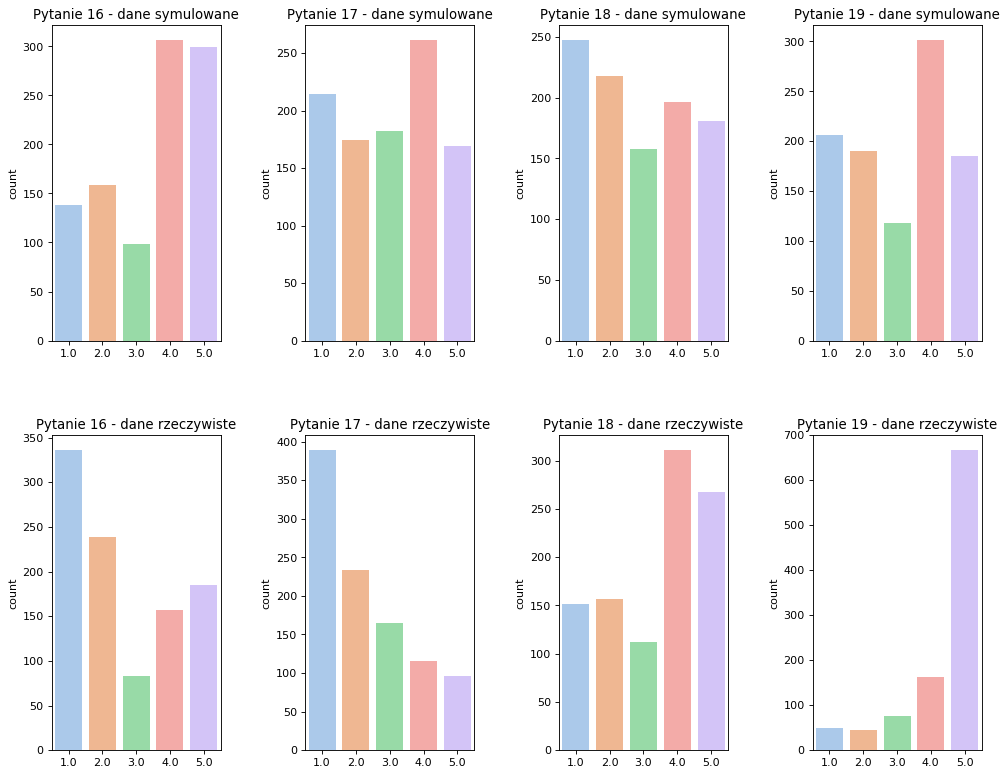

In [68]:
plt.figure(figsize=(15, 12), dpi=80)
Grid_plot = plt.GridSpec(2, 4, wspace = 0.5,
                         hspace = 0.3)

sns.set_palette("pastel")

#Q16 simulated
plt.subplot(Grid_plot[0, 0])
sns.countplot(x=df_sim_1.Question16A)
#plt.title('Question 1 - with \n '+ str(null_series[0]/10) + '% nulls dropped')
plt.title('Pytanie 16 - dane symulowane')
plt.xlabel('')

#Q17 simulated
plt.subplot(Grid_plot[0, 1])
sns.countplot(x=df_sim_1.Question17A)
#plt.title('Question 2 - with \n'+ str(null_series[1]/10) + '% nulls dropped')
plt.title('Pytanie 17 - dane symulowane')
plt.xlabel('')

#Q18 simulated
plt.subplot(Grid_plot[0, 2])
sns.countplot(x=df_sim_1.Question18A)
#plt.title('Question 3 - with \n'+ str(null_series[2]/10) + '% nulls dropped')
plt.title('Pytanie 18 - dane symulowane')
plt.xlabel('')

#Q19 simulated
plt.subplot(Grid_plot[0, 3])
sns.countplot(x=df_sim_1.Question19A)
#plt.title('Question1 - with \n'+ str(null_series[3]/10) + '% nulls dropped')
plt.title('Pytanie 19 - dane symulowane')
plt.xlabel('')

#Q16 real
plt.subplot(Grid_plot[1, 0])
sns.countplot(x=df_answers_sampled.Question16A)
#plt.title('Question 1 - with \n '+ str(null_series[0]/10) + '% nulls dropped')
plt.title('Pytanie 16 - dane rzeczywiste')
plt.xlabel('')

#Q17 real
plt.subplot(Grid_plot[1, 1])
sns.countplot(x=df_answers_sampled.Question17A)
#plt.title('Question 2 - with \n'+ str(null_series[1]/10) + '% nulls dropped')
plt.title('Pytanie 17 - dane rzeczywiste')
plt.xlabel('')

#Q18 real
plt.subplot(Grid_plot[1, 2])
sns.countplot(x=df_answers_sampled.Question18A)
#plt.title('Question 3 - with \n'+ str(null_series[2]/10) + '% nulls dropped')
plt.title('Pytanie 18 - dane rzeczywiste')
plt.xlabel('')

#Q19 real
plt.subplot(Grid_plot[1, 3])
sns.countplot(x=df_answers_sampled.Question19A)
#plt.title('Question1 - with \n'+ str(null_series[3]/10) + '% nulls dropped')
plt.title('Pytanie 19 - dane rzeczywiste')
plt.xlabel('')

### Braki danych
Po ocenie zasymulowanych danych do wygenerowanych odpowiedzi na pytania wprowadzone zostaną całkowicie przypadkowo braki, przy pomocy funkcji <font color = blue> missing_data </font>. Ilość braków jest wybierana losowo z zakresu 15 do 45% wszystkich wartości.

In [13]:
df_miss_1 = missing_data(df_sim_1)

In [14]:
df_sim_1.iloc[:,:10].head(10)

,Question1A,Question2A,Question3A,Question4A,Question5A,Question6A,Question7A,Question8A,Question9A,Question10A
0,1.0,5.0,5.0,1.0,1.0,4.0,2.0,5.0,5.0,1.0
1,1.0,5.0,5.0,5.0,1.0,5.0,1.0,1.0,5.0,1.0
2,1.0,5.0,4.0,4.0,1.0,4.0,4.0,1.0,2.0,1.0
3,4.0,5.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0
4,4.0,5.0,5.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0
5,2.0,1.0,1.0,1.0,3.0,2.0,2.0,1.0,4.0,3.0
6,1.0,5.0,4.0,3.0,2.0,4.0,2.0,4.0,2.0,1.0
7,3.0,5.0,3.0,2.0,1.0,3.0,3.0,1.0,1.0,1.0
8,3.0,5.0,4.0,3.0,1.0,3.0,1.0,4.0,2.0,4.0
9,1.0,5.0,4.0,3.0,3.0,5.0,4.0,2.0,1.0,1.0


In [15]:
df_miss_1.iloc[:,:10].head(10)

,Question1A,Question2A,Question3A,Question4A,Question5A,Question6A,Question7A,Question8A,Question9A,Question10A
0,NaN,5.0,5.0,1.0,1.0,4.0,NaN,5.0,NaN,NaN
1,1.0,NaN,5.0,5.0,NaN,NaN,1.0,1.0,NaN,1.0
2,1.0,5.0,4.0,NaN,NaN,4.0,NaN,NaN,2.0,1.0
3,4.0,NaN,2.0,1.0,NaN,1.0,NaN,2.0,NaN,1.0
4,4.0,5.0,5.0,1.0,4.0,1.0,1.0,2.0,1.0,NaN
5,2.0,1.0,1.0,NaN,3.0,2.0,2.0,1.0,NaN,3.0
6,1.0,NaN,4.0,3.0,2.0,4.0,2.0,4.0,2.0,1.0
7,NaN,5.0,3.0,2.0,NaN,3.0,3.0,1.0,1.0,1.0
8,NaN,5.0,4.0,3.0,1.0,3.0,1.0,4.0,2.0,NaN
9,NaN,5.0,NaN,NaN,NaN,5.0,4.0,NaN,1.0,1.0


Tabela poniżej przedstawia liczbę braków danych w każdej z kolumn

In [16]:
null_series = df_miss_1.isnull().sum()
null_series

Question1A         407
Question2A         351
Question3A         422
Question4A         341
Question5A         398
Question6A         166
Question7A         244
Question8A         257
Question9A         242
Question10A        238
Question11A        334
Question12A        182
Question13A        155
Question14A        301
Question15A        178
Question16A        354
Question17A        166
Question18A        229
Question19A        427
Question20A        245
country              0
education_level      0
home_area            0
gender               0
age                  0
race                 0
marital_status       0
siblings             0
dtype: int64

#### Usunięcie obserwacji z brakującymi danymi
Jak wskazują poniższe wykresy rozkłady po usunięciu obserwacji, których wartości brakuje całkowicie przypadkowo (MCAR) nie zmieniają struktury odpowiedzi. Jednakże, w większości przypadków braki nie są całkowicie przypadkowe więc należy sprawdzić różnego typu imputacje danych.

Text(0.5, 0, '')

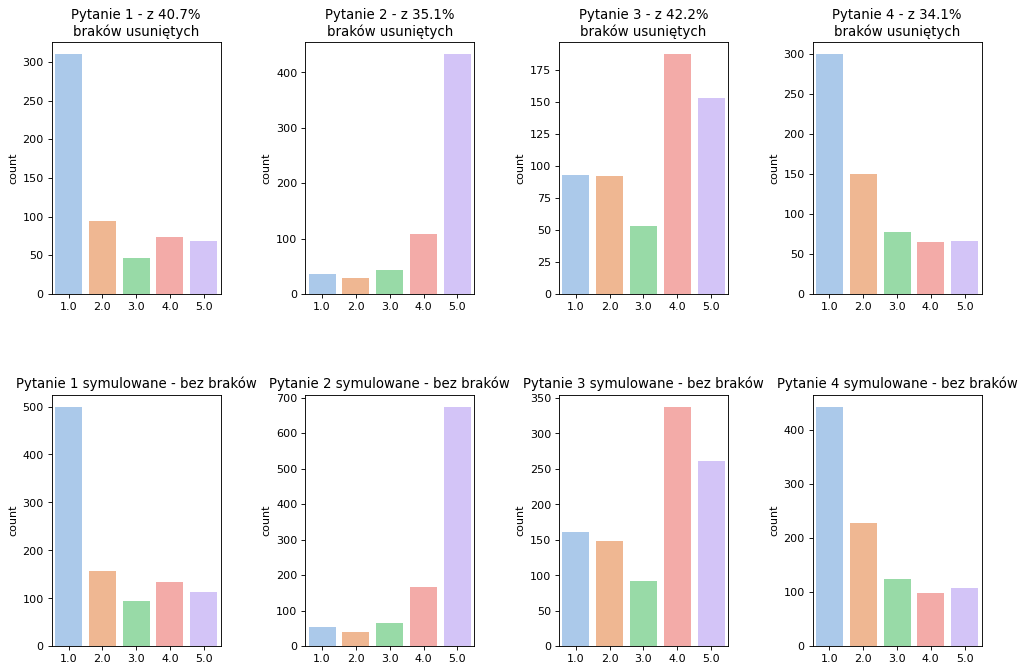

In [17]:
plt.figure(figsize=(15, 10), dpi=80)
Grid_plot = plt.GridSpec(2, 4, wspace = 0.5,
                         hspace = 0.4)

sns.set_palette("pastel")

df_miss_null_drop = df_miss_1
#Q1 NULL
plt.subplot(Grid_plot[0, 0])
sns.countplot(x=df_miss_1.Question1A.dropna())
#plt.title('Question 1 - with \n '+ str(null_series[0]/10) + '% nulls dropped')
plt.title('Pytanie 1 - z '+ str(null_series[0]/10) + '%\nbraków usuniętych')
plt.xlabel('')

#Q2 NULL
plt.subplot(Grid_plot[0, 1])
sns.countplot(x=df_miss_1.Question2A.dropna())
#plt.title('Question 2 - with \n'+ str(null_series[1]/10) + '% nulls dropped')
plt.title('Pytanie 2 - z '+ str(null_series[1]/10) + '%\nbraków usuniętych')
plt.xlabel('')

#Q3 NULL
plt.subplot(Grid_plot[0, 2])
sns.countplot(x=df_miss_1.Question3A.dropna())
#plt.title('Question 3 - with \n'+ str(null_series[2]/10) + '% nulls dropped')
plt.title('Pytanie 3 - z '+ str(null_series[2]/10) + '%\nbraków usuniętych')
plt.xlabel('')

#Q4 NULL
plt.subplot(Grid_plot[0, 3])
sns.countplot(x=df_miss_1.Question4A.dropna())
#plt.title('Question1 - with \n'+ str(null_series[3]/10) + '% nulls dropped')
plt.title('Pytanie 4 - z '+ str(null_series[3]/10) + '%\nbraków usuniętych')
plt.xlabel('')

#Q1 FULL
plt.subplot(Grid_plot[1, 0])
sns.countplot(x=df_sim_1.Question1A)
#plt.title('Question 1 simulated - full')
plt.title('Pytanie 1 symulowane - bez braków')
plt.xlabel('')

#Q2 FULL
plt.subplot(Grid_plot[1, 1])
sns.countplot(x=df_sim_1.Question2A)
#plt.title('Question 2 - full')
plt.title('Pytanie 2 symulowane - bez braków')
plt.xlabel('')

#Q3 FULL
plt.subplot(Grid_plot[1, 2])
sns.countplot(x=df_sim_1.Question3A)
#plt.title('Question 3 - full')
plt.title('Pytanie 3 symulowane - bez braków')
plt.xlabel('')

#Q4 FULL
plt.subplot(Grid_plot[1, 3])
sns.countplot(x=df_sim_1.Question4A)
#plt.title('Question 4 - full')
plt.title('Pytanie 4 symulowane - bez braków')
plt.xlabel('')

#### Porównanie metod imputacji danych

Pierwszym sposobem imputacji danych jest uzupełnienie brakujących wartości przeciętną wartością lub medianą. Funkcja imputująca przyuczana jest na podstawie rzeczywistych ankiet, aby następnie uzupełnić braki w zasymulowanej tabeli z brakami - *df_miss_1*.

In [18]:
df_miss_questions = df_miss_1.iloc[:,:20]
df_imp_mean = df_miss_questions.copy()
df_imp_median = df_miss_questions.copy()
for col in df_imp_mean.columns:
    przecietna = round(df_answers[col].mean())
    df_imp_mean[col] = df_imp_mean[col].fillna(przecietna)
for col in df_imp_median.columns:
    mediana = df_answers[col].median()
    df_imp_median[col] = df_imp_median[col].fillna(mediana)

Text(0.5, 0, '')

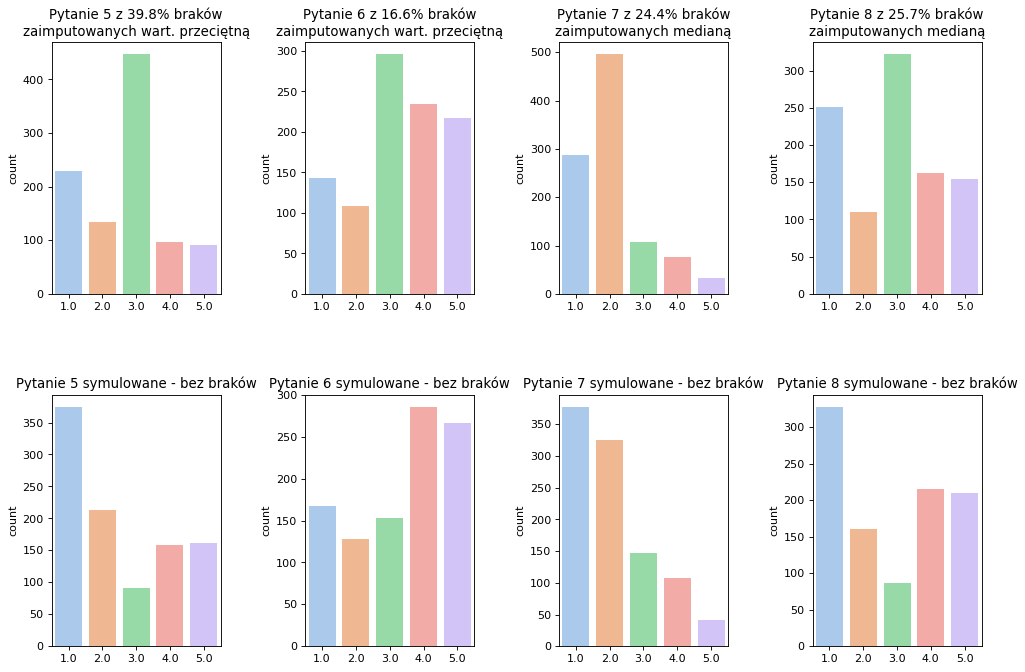

In [19]:
plt.figure(figsize=(15, 10), dpi=80)
Grid_plot = plt.GridSpec(2, 4, wspace = 0.5,
                         hspace = 0.4)

sns.set_palette("pastel")

#Q5 imputed
plt.subplot(Grid_plot[0, 0])
sns.countplot(x=df_imp_mean.Question5A)
#plt.title('Question 1 - with \n '+ str(null_series[0]/10) + '% nulls imputed with mean')
plt.title('Pytanie 5 z '+ str(null_series[4]/10) + '% braków\nzaimputowanych wart. przeciętną')
plt.xlabel('')

#Q6 imputed
plt.subplot(Grid_plot[0, 1])
sns.countplot(x=df_imp_mean.Question6A)
#plt.title('Question 2 - with \n'+ str(null_series[1]/10) + '% nulls imputed with mean')
plt.title('Pytanie 6 z '+ str(null_series[5]/10) + '% braków\nzaimputowanych wart. przeciętną')
plt.xlabel('')

#Q7 imputed
plt.subplot(Grid_plot[0, 2])
sns.countplot(x=df_imp_median.Question7A)
#plt.title('Question 3 - with \n'+ str(null_series[2]/10) + '% nulls imputed with median')
plt.title('Pytanie 7 z '+ str(null_series[6]/10) + '% braków\nzaimputowanych medianą')
plt.xlabel('')

#Q8 imputed
plt.subplot(Grid_plot[0, 3])
sns.countplot(x=df_imp_median.Question8A)
#plt.title('Question1 - with \n'+ str(null_series[3]/10) + '% nulls imputed with median')
plt.title('Pytanie 8 z '+ str(null_series[7]/10) + '% braków\nzaimputowanych medianą')
plt.xlabel('')

#Q5 FULL
plt.subplot(Grid_plot[1, 0])
sns.countplot(x=df_sim_1.Question5A)
#plt.title('Question 1 - full')
plt.title('Pytanie 5 symulowane - bez braków')
plt.xlabel('')

#Q6 FULL
plt.subplot(Grid_plot[1, 1])
sns.countplot(x=df_sim_1.Question6A)
#plt.title('Question 2 - full')
plt.title('Pytanie 6 symulowane - bez braków')
plt.xlabel('')

#Q7 FULL
plt.subplot(Grid_plot[1, 2])
sns.countplot(x=df_sim_1.Question7A)
#plt.title('Question 3 - full')
plt.title('Pytanie 7 symulowane - bez braków')
plt.xlabel('')

#Q8 FULL
plt.subplot(Grid_plot[1, 3])
sns.countplot(x=df_sim_1.Question8A)
#plt.title('Question 4 - full')
plt.title('Pytanie 8 symulowane - bez braków')
plt.xlabel('')

Jak możnaby zakładać, wykresy wskazują na znaczące zwiększenie się koncentracji centralnej rozkładów po wprowadzeniu zmiennych przeciętnych lub mediany. W przypadku imputacji tak dużej liczby danych (~20%), należy zastanowić się nad użytecznością danych w dalszej analizie ze względu na znaczące zwiększenie kurtozy. Na podstawie wykresów można sądzić, że wykorzystanie mediany w takim wypadku wpływa nieznacznie mniej negatywnie na odwzorowanie rozkładu zmiennej.

Ostatnią sprawdzaną metodą imputacji jest wykorzystanie analizy skupień,a dokładniej klasyfikacji metodą najbliższego sąsiada.
Klasyfikator zostanie przyuczony przy pomocy danych o rzeczywistych ankietach, a następnie oszacuje brakujące odpowiedzi na podstawie pozostałych wartości.

In [20]:
#kodowanie zmiennych aby móc wykorzystać wszystkie wartości w klasyfikatorze
le = LabelEncoder()
features = df_answers.copy()
features_missing = df_miss_1.copy()
for feat in features.columns[20:]:
    if feat == 'age':
        continue
    features[feat] = le.fit_transform(features[feat].astype(str))
    features_missing[feat] = le.transform(features_missing[feat].astype(str))

In [21]:
imp_KNN = KNNImputer(n_neighbors = 1)
imp_KNN.fit(features)

KNNImputer(n_neighbors=1)

In [22]:
imp_KNN_arr = imp_KNN.transform(features_missing)
df_imp_KNN = pd.DataFrame(imp_KNN_arr,
    columns = 
    ['Question1A',
    'Question2A',
    'Question3A',
    'Question4A',
    'Question5A',
    'Question6A',
    'Question7A',
    'Question8A',
    'Question9A',
    'Question10A',
    'Question11A',
    'Question12A',
    'Question13A',
    'Question14A',
    'Question15A',
    'Question16A',
    'Question17A',
    'Question18A',
    'Question19A',
    'Question20A',
    'country',
    'education_level',
    'home_area',
    'gender',
    'age',
    'race',
    'marital_status',
    'siblings'])

In [23]:
#tablica danych zaimputowana przy pomocy algorytmu najbliższego sąsiada
#df_imp_KNN = round(df_imp_KNN)
df_imp_KNN.head(4)

,Question1A,Question2A,Question3A,Question4A,Question5A,Question6A,Question7A,Question8A,Question9A,Question10A,...,Question19A,Question20A,country,education_level,home_area,gender,age,race,marital_status,siblings
0,4.0,5.0,5.0,1.0,1.0,4.0,2.0,5.0,4.0,2.0,...,5.0,4.0,3.0,3.0,1.0,1.0,41.0,6.0,1.0,0.0
1,1.0,3.0,5.0,5.0,3.0,5.0,1.0,1.0,5.0,1.0,...,3.0,1.0,1.0,3.0,2.0,1.0,28.0,6.0,1.0,1.0
2,1.0,5.0,4.0,4.0,2.0,4.0,1.0,2.0,2.0,1.0,...,2.0,1.0,3.0,1.0,1.0,0.0,60.0,6.0,0.0,0.0
3,4.0,4.0,2.0,1.0,4.0,1.0,1.0,2.0,2.0,1.0,...,5.0,2.0,2.0,3.0,0.0,0.0,21.0,6.0,1.0,1.0


In [24]:
df_miss_1.head(4)

,Question1A,Question2A,Question3A,Question4A,Question5A,Question6A,Question7A,Question8A,Question9A,Question10A,...,Question19A,Question20A,country,education_level,home_area,gender,age,race,marital_status,siblings
0,NaN,5.0,5.0,1.0,1.0,4.0,NaN,5.0,NaN,NaN,...,5.0,4.0,United States of America,University degree,Suburban,Male,41.0,White,Never married,one sibling
1,1.0,NaN,5.0,5.0,NaN,NaN,1.0,1.0,NaN,1.0,...,3.0,NaN,Canada,University degree,Urban,Male,28.0,White,Never married,only child
2,1.0,5.0,4.0,NaN,NaN,4.0,NaN,NaN,2.0,1.0,...,NaN,1.0,United States of America,High school,Suburban,Female,60.0,White,Currently married,one sibling
3,4.0,NaN,2.0,1.0,NaN,1.0,NaN,2.0,NaN,1.0,...,NaN,2.0,United Kingdom,University degree,Rural,Female,21.0,White,Never married,only child


In [25]:
df_sim_1.head(4)

,Question1A,Question2A,Question3A,Question4A,Question5A,Question6A,Question7A,Question8A,Question9A,Question10A,...,Question19A,Question20A,country,education_level,home_area,gender,age,race,marital_status,siblings
0,1.0,5.0,5.0,1.0,1.0,4.0,2.0,5.0,5.0,1.0,...,5.0,4.0,United States of America,University degree,Suburban,Male,41.0,White,Never married,one sibling
1,1.0,5.0,5.0,5.0,1.0,5.0,1.0,1.0,5.0,1.0,...,3.0,1.0,Canada,University degree,Urban,Male,28.0,White,Never married,only child
2,1.0,5.0,4.0,4.0,1.0,4.0,4.0,1.0,2.0,1.0,...,1.0,1.0,United States of America,High school,Suburban,Female,60.0,White,Currently married,one sibling
3,4.0,5.0,2.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,4.0,2.0,United Kingdom,University degree,Rural,Female,21.0,White,Never married,only child


Text(0.5, 0, '')

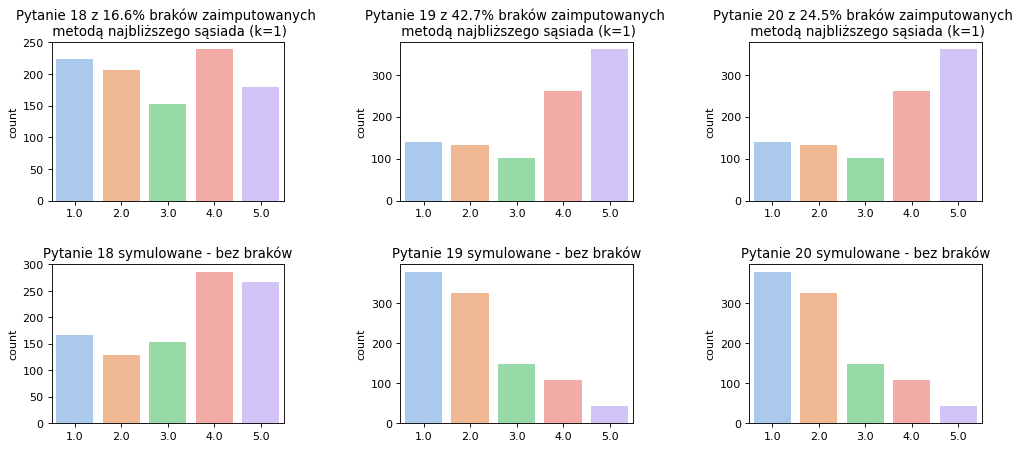

In [26]:
plt.figure(figsize=(15, 10), dpi=80)
Grid_plot = plt.GridSpec(3, 3, wspace = 0.5,
                         hspace = 0.4)

sns.set_palette("pastel")


#Q18 imputed
plt.subplot(Grid_plot[0, 0])
sns.countplot(x=df_imp_KNN.Question18A)
#plt.title('Question 2 - with \n'+ str(null_series[1]/10) + '% nulls imputed with mean')
plt.title('Pytanie 18 z '+ str(null_series[5]/10) + '% braków zaimputowanych \n metodą najbliższego sąsiada (k=1)')
plt.xlabel('')

#Q19 imputed
plt.subplot(Grid_plot[0, 1])
sns.countplot(x=df_imp_KNN.Question19A)
#plt.title('Question 3 - with \n'+ str(null_series[2]/10) + '% nulls imputed with median')
plt.title('Pytanie 19 z '+ str(null_series[18]/10) + '% braków zaimputowanych \n metodą najbliższego sąsiada (k=1)')
plt.xlabel('')

#Q20 imputed
plt.subplot(Grid_plot[0, 2])
sns.countplot(x=df_imp_KNN.Question19A)
#plt.title('Question 3 - with \n'+ str(null_series[2]/10) + '% nulls imputed with median')
plt.title('Pytanie 20 z '+ str(null_series[19]/10) + '% braków zaimputowanych \n metodą najbliższego sąsiada (k=1)')
plt.xlabel('')

#Q18 FULL
plt.subplot(Grid_plot[1, 0])
sns.countplot(x=df_sim_1.Question6A)
#plt.title('Question 2 - full')
plt.title('Pytanie 18 symulowane - bez braków')
plt.xlabel('')

#Q19 FULL
plt.subplot(Grid_plot[1, 1])
sns.countplot(x=df_sim_1.Question7A)
#plt.title('Question 3 - full')
plt.title('Pytanie 19 symulowane - bez braków')
plt.xlabel('')

#Q20 FULL
plt.subplot(Grid_plot[1, 2])
sns.countplot(x=df_sim_1.Question7A)
#plt.title('Question 3 - full')
plt.title('Pytanie 20 symulowane - bez braków')
plt.xlabel('')



Powyższe wykresy wskazują, że algorytm dość dobrze zaimputował zmienne w przypadku pytania 18. Natomiast jeżeli chodzi o pytanie 19 i 20 to imputacja okazała się całkowicie niedopasowana do zasymulowanych danych podnosząc niesłusznie liczbę obserwacji o wartościach 4 i 5. Metoda ta powinna zostać przetestowana wielokrotnie, gdyż możliwe jest odnalezienie mniej licznej kombinacji zmiennych, która znacznie lepiej sklasyfikowałaby odpowiedzi. Możliwe jest również, że same zmienne pochodzące z metryk nie są rzeczywiście skorelowane z odpowiedziami i brakuje pewnych ocen aspektów osób do prawidłowego oszacowania odpowiedzi. Poniżej widoczne jest porównanie odpowiedzi zasymulowanych i zaimputowanych metodą najbliższego sąsiada z rozkładem zmiennych rzeczywistych odpowiedzi. Widoczne są podobne rozbieżności, co w przypadku zmiennych symulowanych (częstsze występowanie wartości 4 i 5). Rozbieżności te potwierdzają założenia, o trudności z imputacją danych ze względu na zbyt uśrednione wyniki odpowiedzi w symulacji, które zauważon były już w trakcie porównania rozkładu wyników symulacji i wyników rzeczywistych. 

Text(0.5, 0, '')

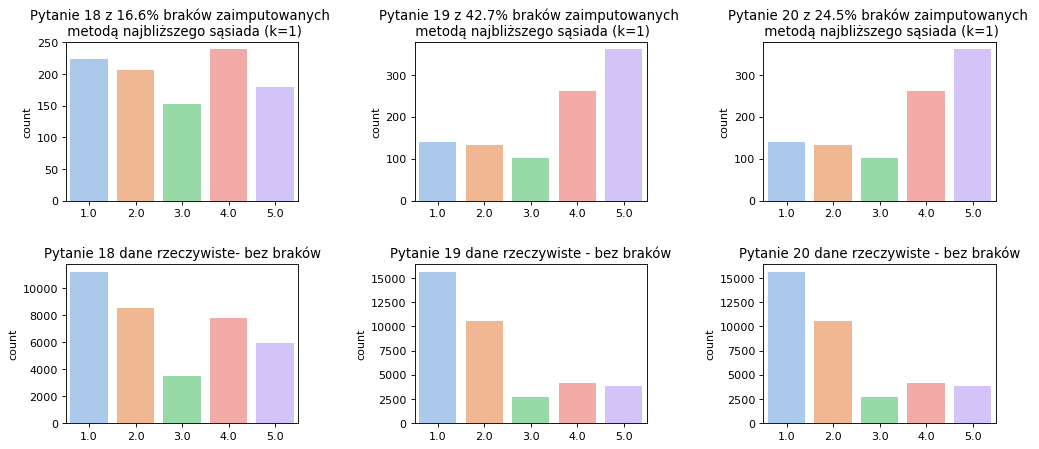

In [27]:
plt.figure(figsize=(15, 10), dpi=80)
Grid_plot = plt.GridSpec(3, 3, wspace = 0.5,
                         hspace = 0.4)

sns.set_palette("pastel")

#Q18 imputed
plt.subplot(Grid_plot[0, 0])
sns.countplot(x=df_imp_KNN.Question18A)
#plt.title('Question 2 - with \n'+ str(null_series[1]/10) + '% nulls imputed with mean')
plt.title('Pytanie 18 z '+ str(null_series[5]/10) + '% braków zaimputowanych \n metodą najbliższego sąsiada (k=1)')
plt.xlabel('')

#Q19 imputed
plt.subplot(Grid_plot[0, 1])
sns.countplot(x=df_imp_KNN.Question19A)
#plt.title('Question 3 - with \n'+ str(null_series[2]/10) + '% nulls imputed with median')
plt.title('Pytanie 19 z '+ str(null_series[18]/10) + '% braków zaimputowanych \n metodą najbliższego sąsiada (k=1)')
plt.xlabel('')

#Q20 imputed
plt.subplot(Grid_plot[0, 2])
sns.countplot(x=df_imp_KNN.Question19A)
#plt.title('Question 3 - with \n'+ str(null_series[2]/10) + '% nulls imputed with median')
plt.title('Pytanie 20 z '+ str(null_series[19]/10) + '% braków zaimputowanych \n metodą najbliższego sąsiada (k=1)')
plt.xlabel('')

#Q18 FULL
plt.subplot(Grid_plot[1, 0])
sns.countplot(x=df_answers.Question6A)
#plt.title('Question 2 - full')
plt.title('Pytanie 18 dane rzeczywiste- bez braków')
plt.xlabel('')

#Q19 FULL
plt.subplot(Grid_plot[1, 1])
sns.countplot(x=df_answers.Question7A)
#plt.title('Question 3 - full')
plt.title('Pytanie 19 dane rzeczywiste - bez braków')
plt.xlabel('')

#Q20 FULL
plt.subplot(Grid_plot[1, 2])
sns.countplot(x=df_answers.Question7A)
#plt.title('Question 3 - full')
plt.title('Pytanie 20 dane rzeczywiste - bez braków')
plt.xlabel('')